In [3]:
import numpy as np
import pandas as pd
#pd.core.common.is_list_like = pd.api.types.is_list_like
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas_datareader as pdr
#from pandas_datareader import data as pdr
import fix_yahoo_finance as fyf
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pickle
#% matplotlib inline

### Obter top 5 do índice bovespa:

In [1]:
def get_html_page(url):
    page = urlopen(url)
    soup_page = BeautifulSoup(page, 'html.parser')
    return soup_page

def get_indicator_assets(html_soup_page):
    rgRows = html_soup_page.findAll('tr', attrs={'class':'rgRow'})
    rgAltRows = html_soup_page.findAll('tr', attrs={'class':'rgAltRow'})
    rgRows = rgRows+rgAltRows

    indicator_assets = []
    for rgRow in rgRows:
        rawData = rgRow.findAll('span')
        codigo = rawData[0].contents[0]
        acao   = rawData[1].contents[0]
        tipo   = rawData[2].contents[0]
        qtd_teorica = rawData[3].contents[0]
        participacao = rawData[4].contents[0]
        asset_data = [codigo, acao, tipo, qtd_teorica, participacao]
        indicator_assets.append(asset_data)
    return indicator_assets

In [ ]:
# IBOV
url = 'http://bvmf.bmfbovespa.com.br/indices/ResumoCarteiraTeorica.aspx?Indice=IBOV&idioma=pt-br'
# IBVX -> 'http://bvmf.bmfbovespa.com.br/indices/ResumoCarteiraTeorica.aspx?Indice=IVBX&amp;idioma=pt-br'
soup_page = get_html_page(url)
IVBX2_index = get_indicator_assets(soup_page)
if (len(IVBX2_index) == 0):
    print('ERROR READING - TRY AGAIN')
    
# display(IVBX2_index)

In [ ]:
assets_codes = np.array(IVBX2_index)[:,0]
assets_codes_SA = [x + '.SA' for x in assets_codes]
print(assets_codes_SA)

### Loading data:

In [ ]:
### Get data from yahoo finance
stock_data = {}
volume_data = {}
for asset_code in assets_codes_SA:
    print('Downloading: ', asset_code)
    stock_data[asset_code] = pdr.get_data_yahoo(asset_code, start='2015-01-01')
    volume_data[asset_code] = stock_data[asset_code]['Volume'].sum()

# Save stocks to file
with open('stock_data.pkl', 'wb') as f:
    pickle.dump([stock_data, volume_data], f)

In [4]:
# Load stocks from file
with open('stock_data.pkl', 'rb') as f:
    stock_data, volume_data = pickle.load(f)

### TOP 5:

In [5]:
top_5_liquid = sorted(volume_data.items(), key = lambda x:x[1])[-5:]
#display(top_5_liquid)
top_5_keys = [asset[0] for asset in top_5_liquid]
print(top_5_keys)

['ITUB4.SA', 'GOAU4.SA', 'USIM5.SA', 'ITSA4.SA', 'PETR4.SA']


In [6]:
def short_and_long_mavg_from_price_df(price_df, short_window, long_window):
    price = price_df.copy()
    
    # MOVING AVERAGE
    fast_ma = price.rolling(short_window).mean()
    slow_ma = price.rolling(long_window).mean()
    price['short_mavg'] = fast_ma
    price['long_mavg'] = slow_ma
    
    # SIGNAL
    price['positions'] = 0.0
    price['positions'][short_window:] = np.where(price['short_mavg'][short_window:] \
                                            > price['long_mavg'][short_window:], 1.0, 0.0)  
    # BUY / SELL
    price['positions_diff'] = price['positions'].diff().copy()
    
    return price




stock_data_adj_close = {}
for asset in top_5_keys:
    price = stock_data[asset][['Adj Close']]
    stock_data_adj_close[asset] = short_and_long_mavg_from_price_df(price, 8, 20)

In [7]:
def plot_asset_mavg_position(asset):
  
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

    ax[0].plot(asset['Adj Close'], label='Close',color='r')
    ax[0].plot(asset['short_mavg'], label='short_mavg')
    ax[0].plot(asset['long_mavg'], label='long_mavg')
    ax[0].set_ylabel("Preço [R$]")
    ax[0].set_xlabel("Data")
    ax[0].set_title("Médias")
    ax[0].legend(loc='upper left')

    ax[1].plot(asset['positions'], label='positions')
    ax[1].plot(asset['positions_diff'], label='positions_diff')
    ax[1].set_ylabel("Posição")
    ax[1].set_xlabel("Data")
    ax[1].legend(loc='lower left')
    
    plt.show()

ITUB4.SA


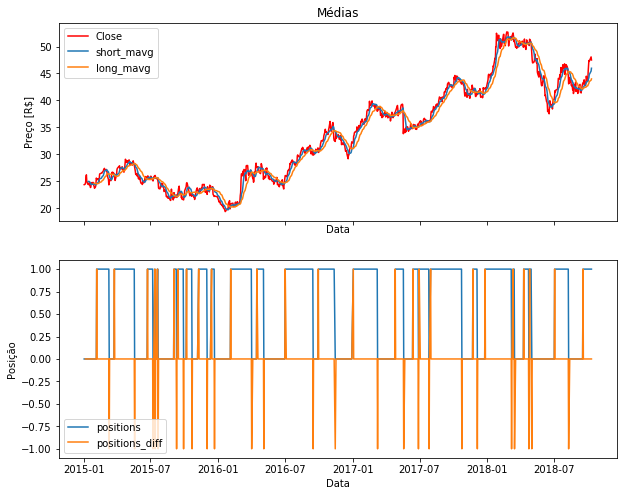

GOAU4.SA


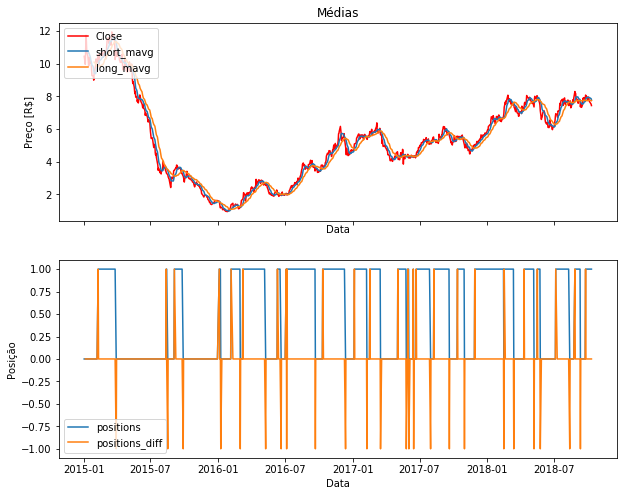

USIM5.SA


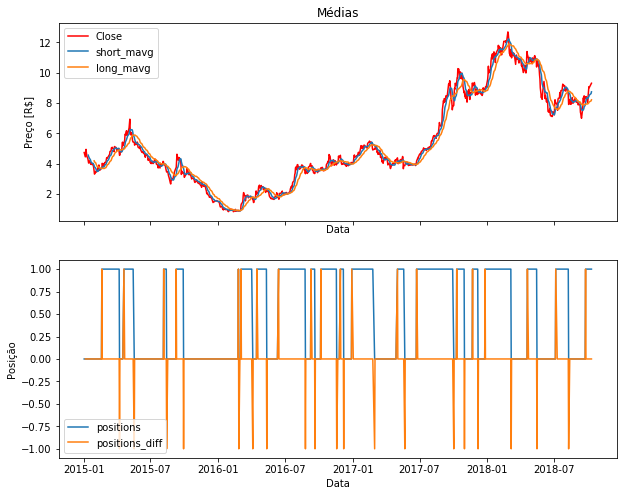

ITSA4.SA


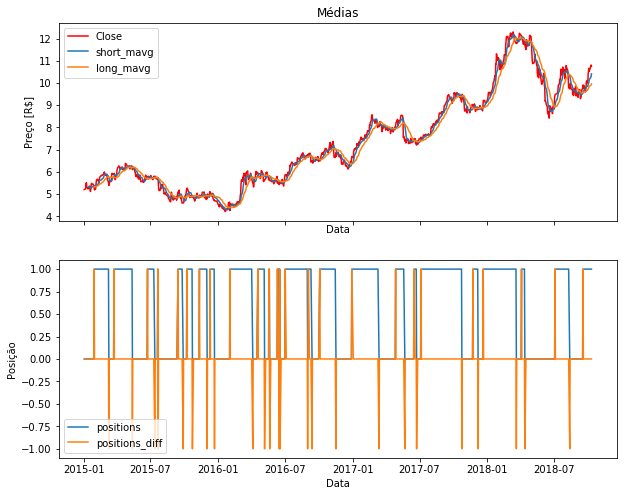

PETR4.SA


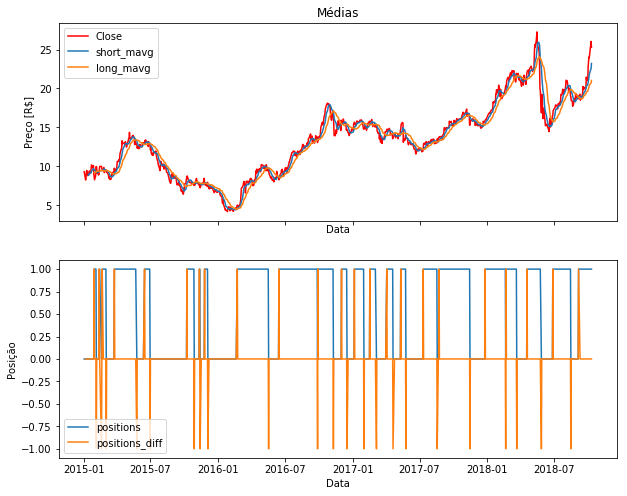

In [8]:
%matplotlib inline
for asset in top_5_keys:
    print(asset)
    signal = stock_data_adj_close[asset]
    
    plot_asset_mavg_position(signal)

In [9]:
def plot_asset_mavg_buy_sell(asset):
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10,8))

    ax1.plot(asset['Adj Close'], lw=2.,label='Close')
    ax1.plot(asset[['short_mavg', 'long_mavg']])

    # Buy
    ax1.plot(asset.loc[asset.positions_diff == 1.0].index, 
             asset.short_mavg[asset.positions_diff == 1.0],
             '^', markersize=10, color='m',label='Buy')
    # Sell
    ax1.plot(asset.loc[asset.positions_diff == -1.0].index, 
             asset.short_mavg[asset.positions_diff == -1.0],
             'v', markersize=10, color='k',label='Sell')
    
    ax1.legend(loc='lower left')      
    ax1.set_ylabel("Preço [R$]")
    ax1.set_xlabel("Data")
    ax1.set_title("Médias")
    ax1.legend(loc='upper left')

    plt.show()

ITUB4.SA


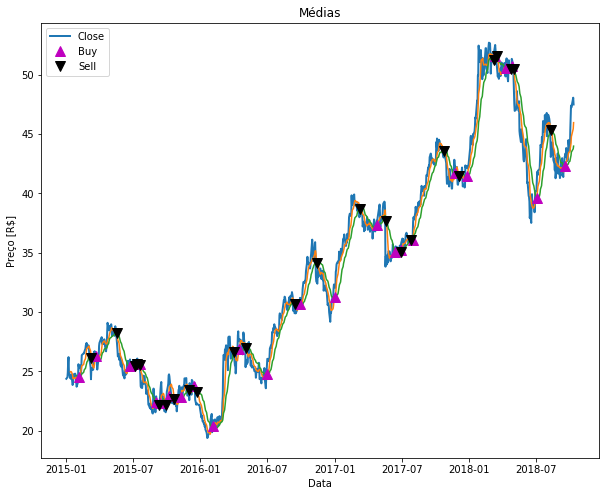

GOAU4.SA


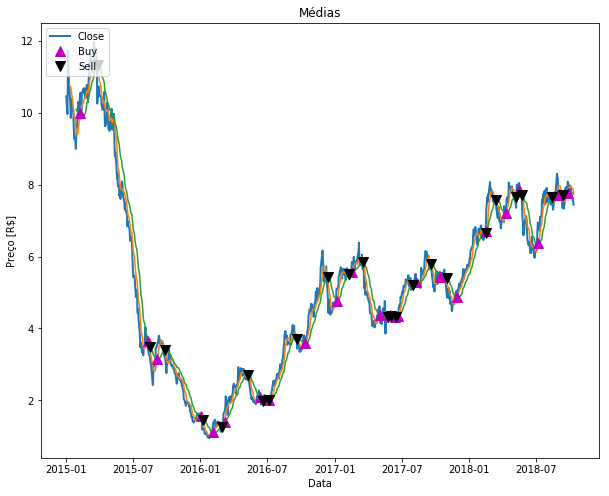

USIM5.SA


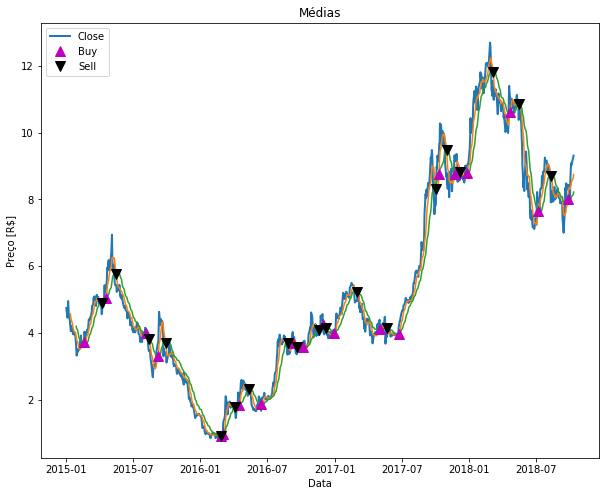

ITSA4.SA


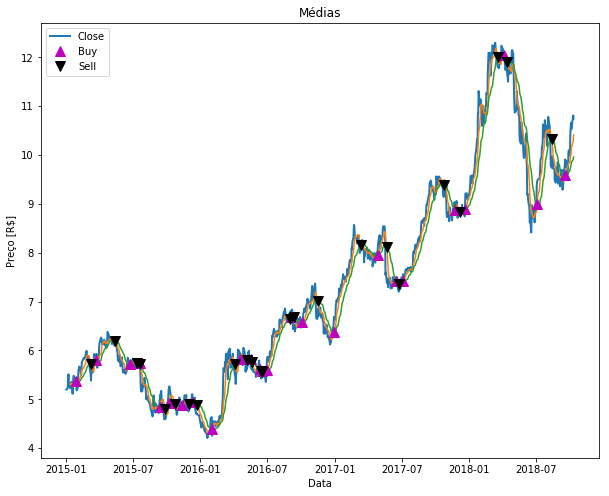

PETR4.SA


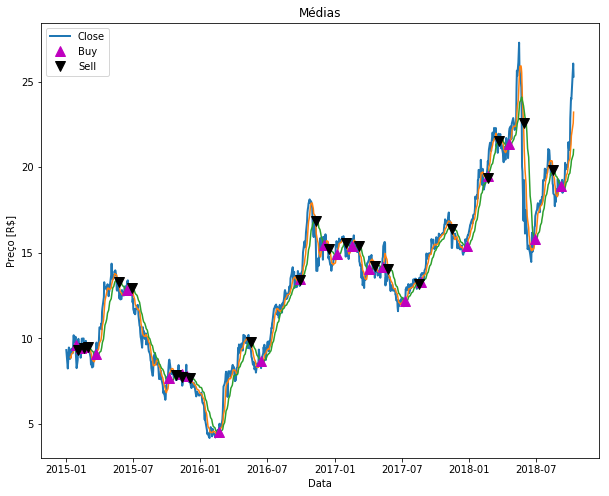

In [10]:
%matplotlib inline
for asset in top_5_keys:
    print(asset)
    signal = stock_data_adj_close[asset]
    
    plot_asset_mavg_buy_sell(signal)

In [ ]:
# def display_full(x):
#     pd.set_option('display.max_rows', len(x))
#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.width', 2000)
#     pd.set_option('display.float_format', '{:20,.2f}'.format)
#     pd.set_option('display.max_colwidth', -1)
#     display(x)
#     pd.reset_option('display.max_rows')
#     pd.reset_option('display.max_columns')
#     pd.reset_option('display.width')
#     pd.reset_option('display.float_format')
#     pd.reset_option('display.max_colwidth')
    
# #%matplotlib notebook

# asset = 'ITUB4.SA'
# signals = stock_data_adj_close[asset]

# display(signals.head())

In [33]:
# Plot while operating, zero otherwise
def get_trading_positions(asset):
    positions = pd.DataFrame(index=asset.index).fillna(0.0)
    positions['Adj Close'] = asset['Adj Close']
    positions['trading_positions'] = asset['positions']

    positions['trading_positions'] = positions['Adj Close'].multiply(positions['trading_positions'], axis=0)
    positions.drop(columns=['Adj Close'], inplace=True)

    return positions

# Get intervals while operating
def get_positon_itervals(price_df):
    bought = price_df[price_df['positions_diff'] >= 1].index
    sold = price_df[price_df['positions_diff'] <= -1].index
    
    if (abs(len(bought)-len(sold))>1):
        print('dimension error')
    if (len(bought) > len(sold)):
        sold = sold.insert(len(sold)+1,price_df.index[-1])
    if (len(bought) < len(sold)):
        bought = bought.insert(len(bought)+1,price_df.index[-1])
        
    bought = bought.tolist()
    sold   = sold.tolist()  
    positions_sell_buy = list(zip(bought,sold))
        
    return positions_sell_buy
    

def get_position_returns(price_df):
    # position = -1 -> SOLD
    # position = 1  -> BOUGHT
    # positions_diff -> START/STOP
    
    price_df['log_prices'] = np.log(price_df['Adj Close'])
    price_df['log_returns'] = 0.0
    positions_sell_buy = get_positon_itervals(price_df)
    for [start, end] in positions_sell_buy:
        with pd.option_context('mode.chained_assignment', None):
            position = price_df[start:end]
            position['log_returns'] = position['log_prices'].diff().fillna(0)
    
    cumulative_log_return = price_df['log_returns'].cumsum()
    price_df['cumulative_returns'] = np.exp(cumulative_log_return) - 1 
    price_df['returns'] = np.exp(price_df['log_returns']) - 1 
    price_df.drop(columns=['log_returns', 'log_prices'], inplace=True)
    
    return price_df

ITUB4.SA


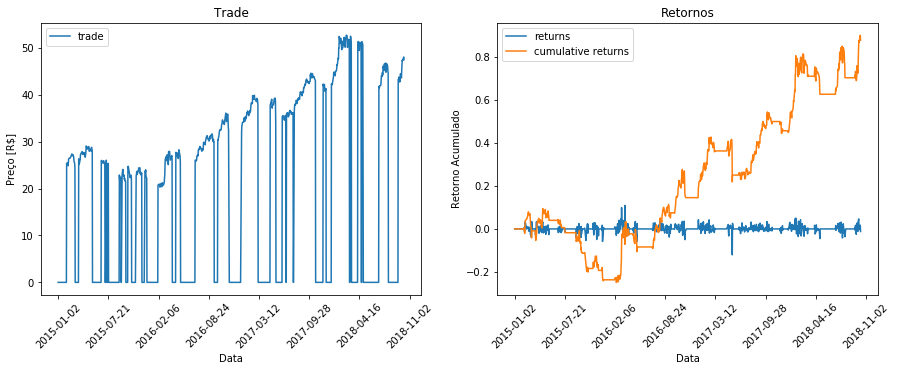

GOAU4.SA


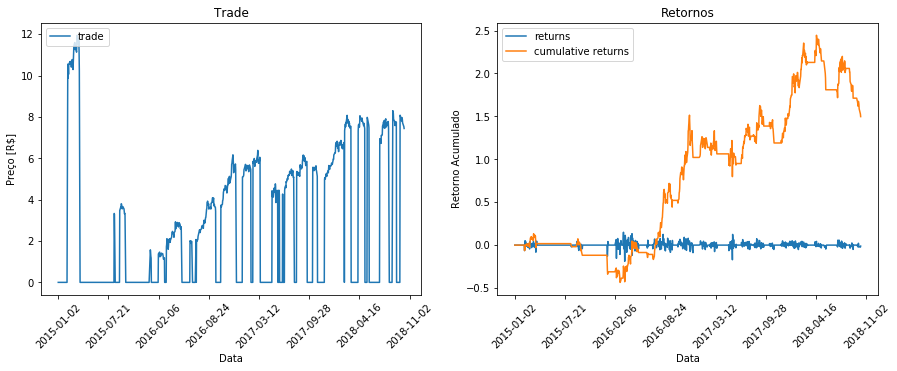

USIM5.SA


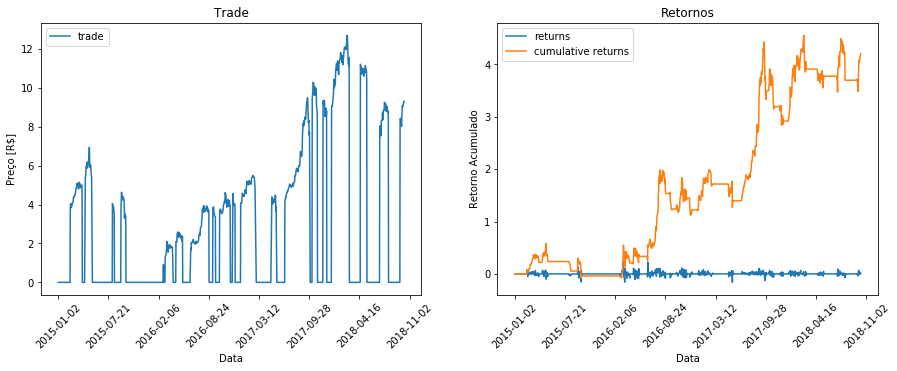

ITSA4.SA


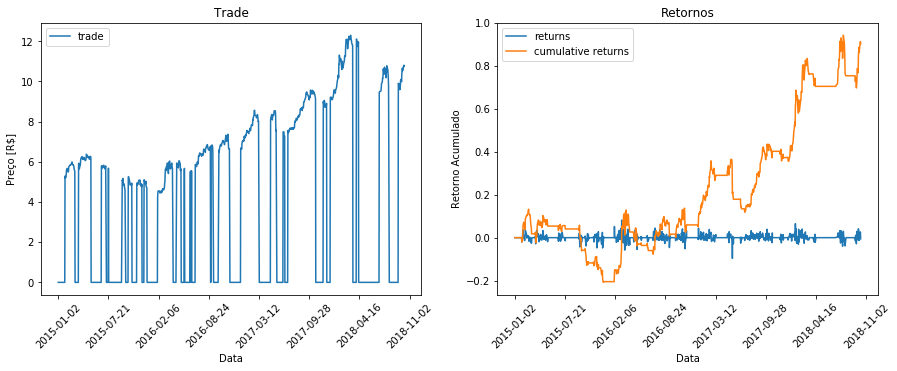

PETR4.SA


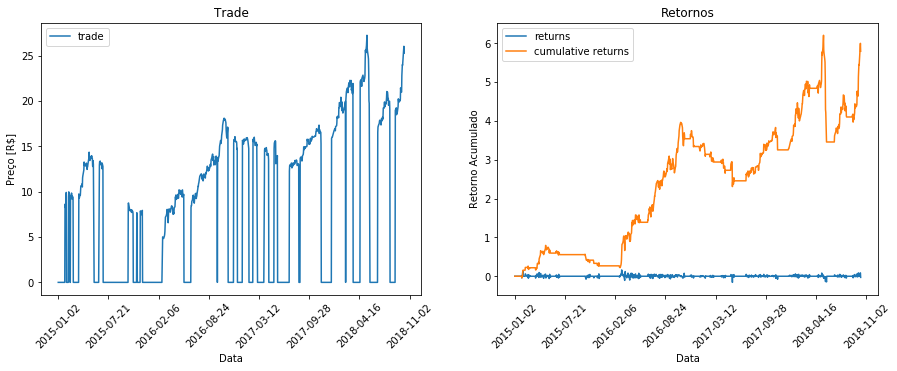

In [35]:
%matplotlib inline
for asset in top_5_keys:
    print(asset)
    signal = stock_data_adj_close[asset]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15,5))
    ax[0].plot(get_trading_positions(signal),label='trade')
    ax[0].legend(loc='upper left')
    for label in ax[0].xaxis.get_ticklabels():
        label.set_rotation(45)
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[0].xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax[0].set_ylabel("Preço [R$]")
    ax[0].set_xlabel("Data")
    ax[0].set_title("Trade")
    
    
    position_returns = get_position_returns(signal)
    ax[1].plot(position_returns['returns'],label='returns')
    ax[1].plot(position_returns['cumulative_returns'],label='cumulative returns')
    ax[1].legend(loc='upper left')
    for label in ax[1].xaxis.get_ticklabels():
        label.set_rotation(45)
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[1].xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax[1].set_ylabel("Retorno Acumulado")
    ax[1].set_xlabel("Data")
    ax[1].set_title("Retornos")
    
    plt.show()

In [36]:
def risk_adjusted_return_indicators(asset):
    position_returns = get_position_returns(asset)
    total_return = position_returns['cumulative_returns'][-1]
    print('total return: ', total_return)
    print('total days: ', len(position_returns)) 

    anualized_return = (total_return + 1) ** (252/len(position_returns)) - 1
    print('* anualized return: ', anualized_return)
    
    daily_std = position_returns['returns'].std()
    anual_std = daily_std * ((252)**(1/2))
    print('* anualized std: ', anual_std)
    
    risk_free = 0.05
    print('* risk free return: ', risk_free)
    print('------------------')
    sharpe_index = (anualized_return - risk_free) / anual_std
    print('SHARPE INDEX:', sharpe_index)
    print('******************\n')    
    
    indicators = {'sharpe_index': sharpe_index}
    return indicators

%matplotlib inline
for asset in top_5_keys:
    print(asset)
    signal = stock_data_adj_close[asset]
    risk_adjusted_return_indicators(signal)


ITUB4.SA
total return:  0.8769610160635226
total days:  942
* anualized return:  0.18346013824309293
* anualized std:  0.22809848382541287
* risk free return:  0.05
------------------
SHARPE INDEX: 0.5850987521041291
******************

GOAU4.SA
total return:  1.4975714205499555
total days:  942
* anualized return:  0.2774454755742679
* anualized std:  0.43955088815064436
* risk free return:  0.05
------------------
SHARPE INDEX: 0.5174497008326304
******************

USIM5.SA
total return:  4.2047740698968585
total days:  942
* anualized return:  0.5547082788221238
* anualized std:  0.47828299387581663
* risk free return:  0.05
------------------
SHARPE INDEX: 1.055250312648934
******************

ITSA4.SA
total return:  0.9018049728941722
total days:  942
* anualized return:  0.18763050617958443
* anualized std:  0.21838167883836868
* risk free return:  0.05
------------------
SHARPE INDEX: 0.6302291790761863
******************

PETR4.SA
total return:  5.793529676358909
total days:  

In [18]:
def macd_from_price_df(price_df, short_window, long_window):
    price = price_df.copy()
    
    # MOVING AVERAGE
    fast_ma = price.rolling(short_window).mean()
    slow_ma = price.rolling(long_window).mean()
    price['short_mavg'] = fast_ma
    price['long_mavg'] = slow_ma
    
    # SIGNAL
    price['positions'] = 0.0
    price['positions'][short_window:] = np.where(price['short_mavg'][short_window:] \
                                            > price['long_mavg'][short_window:], 1.0, 0.0)  
    # BUY / SELL
    price['positions_diff'] = price['positions'].diff().copy()
    
    return price

# def MACD(stock):        
#         stock['26 ema'] = stock['Close'].ewm(span=26,adjust=False).mean() 
#         stock['12 ema'] = stock['Close'].ewm(span=12,adjust=False).mean() 
#         stock['MACD'] = (stock['12 ema'] - stock['26 ema'])
#         stock['Signal Line'] = stock['MACD'].ewm(span=9,adjust=False).mean()
#         stock['HisM'] = stock['MACD'] - stock['Signal Line']
#         return stock     

In [37]:
%matplotlib inline
for asset in top_5_keys:
    print(asset)
    price = stock_data[asset][['Adj Close']]
    
    macd_df = macd_from_price_df(price, 8, 20)
    
    display(risk_adjusted_return_indicators(macd_df))




ITUB4.SA
total return:  0.8769610160635226
total days:  942
* anualized return:  0.18346013824309293
* anualized std:  0.22809848382541287
* risk free return:  0.05
------------------
SHARPE INDEX: 0.5850987521041291
******************



{'sharpe_index': 0.5850987521041291}

GOAU4.SA
total return:  1.4975714205499555
total days:  942
* anualized return:  0.2774454755742679
* anualized std:  0.43955088815064436
* risk free return:  0.05
------------------
SHARPE INDEX: 0.5174497008326304
******************



{'sharpe_index': 0.5174497008326304}

USIM5.SA
total return:  4.2047740698968585
total days:  942
* anualized return:  0.5547082788221238
* anualized std:  0.47828299387581663
* risk free return:  0.05
------------------
SHARPE INDEX: 1.055250312648934
******************



{'sharpe_index': 1.055250312648934}

ITSA4.SA
total return:  0.9018049728941722
total days:  942
* anualized return:  0.18763050617958443
* anualized std:  0.21838167883836868
* risk free return:  0.05
------------------
SHARPE INDEX: 0.6302291790761863
******************



{'sharpe_index': 0.6302291790761863}

PETR4.SA
total return:  5.793529676358909
total days:  942
* anualized return:  0.669547539952438
* anualized std:  0.3899387350712525
* risk free return:  0.05
------------------
SHARPE INDEX: 1.588833024857686
******************



{'sharpe_index': 1.588833024857686}

In [ ]:
# import numpy as np

# def cumulative_return(prices):
#     log_prices = np.log(prices)
#     cumulative_log_return = [0]
#     simple_log_return = []
    
#     for i in range(1, len(log_prices)):
#         cumulative_log_return.append( log_prices[i] - log_prices[i-1] + cumulative_log_return[i-1])
#         simple_log_return.append(log_prices[i] - log_prices[i-1])
    
#     cumulative_return = np.exp(cumulative_log_return[1:]) - 1 
#     simple_return = np.exp(simple_log_return) - 1 
#     returns = {}
#     returns['cumulative_return'] = np.round(cumulative_return,8)
#     returns['simple_return'] = np.round(simple_return,8)
#     return returns
    
# cumulative_return([100,110,90,110,130,130])

In [ ]:
returns = np.array([9, 15, 23, 10, 11, 8, 7, 6, 6, 5])/100
cum_price = 100
price = []
price.append(cum_price)
for ret in returns:
    cum_price = cum_price*(1+ret)
    price.append(cum_price)
    
a_df = pd.DataFrame({'price': price, 'price_log': np.log(price)})
display(a_df.mean())
display(a_df.std())

a_df['log_diff'] = a_df['price_log'].diff().fillna(0)
a_df['cumulative_log_return'] = a_df['log_diff'].cumsum()
a_df['simp_returns'] = np.exp(a_df['log_diff']) - 1 
a_df['returns'] = np.exp(a_df['cumulative_log_return']) - 1 


# a_df['returns_2'] = a_df['price'].pct_change()
# a_df['cumulative_returns_2'] = a_df['returns_2'].cumsum() / a_df['returns_2'].std()

anualized_return = (a_df['returns'][-1:] + 1) ** (1/10) -1
print(anualized_return*100)
# returns = np.exp(cumulative_log_return) - 1 
display(a_df)


In [ ]:
# a = (10+1)**(1/7)-1
# print('Day ret:', a)


# r7d = (10+1)**(7/7)-1
# print('7 days ret:', r7d)

# r2d = (10+1)**(2/7)-1
# print('2 days ret:', r2d)

# r28d = (10+1)**(14/7)-1
# print('28 days ret:', r28d)


# (1 + 0.18346) ** (942/252) - 1

#### Sharp ratio
#### Ulcer Performance Index
#### Maximum Drawdown
#### Beta...